# Data Aggregation

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from datetime import datetime
from typing import Dict, List

import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import plotly.express as px
import plotly.graph_objects as go
from meteostat import Stations, Daily, Point
from scipy.optimize import curve_fit
from sqlalchemy import create_engine

/home/edesz/Downloads/ml-project/.tox/dash/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
config = configparser.ConfigParser()
config.read("../sql.ini")
default_cfg = config["default"]

In [4]:
DB_TYPE = default_cfg["DB_TYPE"]
DB_DRIVER = default_cfg["DB_DRIVER"]
DB_USER = default_cfg["DB_USER"]
DB_PASS = default_cfg["DB_PASS"]
DB_HOST = default_cfg["DB_HOST"]
DB_PORT = default_cfg["DB_PORT"]
DB_NAME = "bikeshare"

In [5]:
# Connect to all databases (required to perform CRUD operations and submit queries)
URI = f"{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

## Get Data

### Connect to Database

In [6]:
engine = create_engine(URI)
conn = engine.connect()

### Query Data from Table

In [7]:
# Name of database table to store merged hourly aggregated data
table_name = "ridership"

In [8]:
%%time
df = pd.read_sql(
    f"""
    SELECT *
    FROM {table_name}
    WHERE station_type = 'start'
    """,
    con=conn
)
df

CPU times: user 58.8 s, sys: 1.35 s, total: 1min
Wall time: 1min 2s


,station_name,year,month,day,hour,user_type,num_trips,duration_min,duration_median,duration_mean,...,neigh_classification_code,neigh_area_latitude,neigh_area_longitude,neigh_transit_stops,neigh_colleges_univs,neigh_cultural_attractions,neigh_places_of_interest,neigh_pop_2016,neigh_youth_15_24,neigh_work_age_25_54
0,Ontario Place Blvd / Lake Shore Blvd W (East),2021,5,30,16,Casual Member,79,300,1320.0,1740.76,...,0,43.6367,-79.4124,63,0,0,10,31180.0,2415.0,23320.0
1,Lake Shore Blvd W / Ontario Dr,2021,5,23,19,Casual Member,73,540,1500.0,2688.49,...,0,43.6367,-79.4124,63,0,0,10,31180.0,2415.0,23320.0
2,Lake Shore Blvd W / Ontario Dr,2021,5,24,19,Casual Member,72,60,1500.0,1632.50,...,0,43.6367,-79.4124,63,0,0,10,31180.0,2415.0,23320.0
3,Lake Shore Blvd W / Ontario Dr,2021,5,24,15,Casual Member,70,60,1560.0,1738.29,...,0,43.6367,-79.4124,63,0,0,10,31180.0,2415.0,23320.0
4,Lake Shore Blvd W / The Boulevard Club,2021,4,10,17,Casual Member,68,480,1260.0,1743.53,...,NIA,43.6367,-79.4393,33,0,1,1,21849.0,2275.0,12440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575279,Lower Simcoe St / Bremner Blvd,2021,6,14,22,Casual Member,1,2820,2820.0,2820.00,...,0,43.6339,-79.3772,103,0,0,50,65913.0,7840.0,45105.0
1575280,Lower Simcoe St / Bremner Blvd,2021,6,15,4,Annual Member,1,240,240.0,240.00,...,0,43.6339,-79.3772,103,0,0,50,65913.0,7840.0,45105.0
1575281,Lower Simcoe St / Bremner Blvd,2021,6,15,6,Annual Member,1,840,840.0,840.00,...,0,43.6339,-79.3772,103,0,0,50,65913.0,7840.0,45105.0
1575282,Lower Simcoe St / Bremner Blvd,2021,6,15,8,Annual Member,1,600,600.0,600.00,...,0,43.6339,-79.3772,103,0,0,50,65913.0,7840.0,45105.0


### Close MySQL Database Connection

In [9]:
conn.close()
engine.dispose()

## Remove Outliers by Average Trip Duration

Show the statistics for the trip durations

In [10]:
df["duration_mean"].describe().to_frame()

,duration_mean
count,1.575284e+06
mean,9.546168e+02
std,1.473800e+03
min,0.000000e+00
25%,4.800000e+02
50%,7.800000e+02
75%,1.140000e+03
max,8.622000e+04


Use trip duration to
- remove sub-one minute trips (trips with an unrealistic duration)
- remove trips with a duration outside the IQR (25%-75% percentiles)
  - these are outliers, since a trip can't be 8.6 X 10^4 seconds (86,000 seconds or 1,437 minutes) in length

In [11]:
%%time
# Removing false start trips
df = df[(df['duration_mean'] >= 60)]

# Removing outliers
q1 = df['duration_mean'].quantile(0.25)
q3 = df['duration_mean'].quantile(0.75)

interquartile_range = q3 - q1

df = df[
    ~(
        (df['duration_mean'] < (q1 - 1.5 * interquartile_range))
         |(df['duration_mean'] > (q3 + 1.5 * interquartile_range))
    )
].reset_index(drop=True)

CPU times: user 796 ms, sys: 140 ms, total: 936 ms
Wall time: 935 ms


## Aggregate to Daily Ridership

In [12]:
%%time
df_daily = df.groupby(
    [
        "station_name",
        "year",
        "month",
        "day",
        "user_type",
    ],
    as_index=False,
).agg(
    {
        "num_trips": "sum",
        "area_name": "min",
        "lat": "min",
        "lon": "min",
        "altitude": "min",
        "capacity": "min",
        "physicalkey": "min",
        "transitcard": "min",
        "phone": "min",
        "neigh_shape_area": "min",
        "neigh_shape_length": "min",
        "neigh_classification": "min",
        "neigh_transit_stops": "min",
        "neigh_colleges_univs": "min",
        "neigh_cultural_attractions": "min",
        "neigh_places_of_interest": "min",
        "neigh_pop_2016": "min",
        "neigh_youth_15_24": "min",
        "neigh_work_age_25_54": "min",
    }
)
df_daily

CPU times: user 30.8 s, sys: 526 ms, total: 31.3 s
Wall time: 30.7 s


,station_name,year,month,day,user_type,num_trips,area_name,lat,lon,altitude,...,neigh_shape_area,neigh_shape_length,neigh_classification,neigh_transit_stops,neigh_colleges_univs,neigh_cultural_attractions,neigh_places_of_interest,neigh_pop_2016,neigh_youth_15_24,neigh_work_age_25_54
0,1 Market St - SMART,2021,2,2,Annual Member,3,Waterfront Communities-The Island (77),43.6470,-79.3707,0.0,...,25629800.0,25382.7,0,103,0,0,50,65913.0,7840.0,45105.0
1,1 Market St - SMART,2021,2,3,Annual Member,1,Waterfront Communities-The Island (77),43.6470,-79.3707,0.0,...,25629800.0,25382.7,0,103,0,0,50,65913.0,7840.0,45105.0
2,1 Market St - SMART,2021,2,4,Annual Member,2,Waterfront Communities-The Island (77),43.6470,-79.3707,0.0,...,25629800.0,25382.7,0,103,0,0,50,65913.0,7840.0,45105.0
3,1 Market St - SMART,2021,2,5,Annual Member,1,Waterfront Communities-The Island (77),43.6470,-79.3707,0.0,...,25629800.0,25382.7,0,103,0,0,50,65913.0,7840.0,45105.0
4,1 Market St - SMART,2021,2,6,Annual Member,1,Waterfront Communities-The Island (77),43.6470,-79.3707,0.0,...,25629800.0,25382.7,0,103,0,0,50,65913.0,7840.0,45105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275603,York University Station (South) - SMART,2021,10,28,Annual Member,1,York University Heights (27),43.7734,-79.5002,0.0,...,25418200.0,25632.3,Neighbourhood Improvement Area,220,1,0,1,27593.0,4750.0,12290.0
275604,York University Station (South) - SMART,2021,10,29,Casual Member,1,York University Heights (27),43.7734,-79.5002,0.0,...,25418200.0,25632.3,Neighbourhood Improvement Area,220,1,0,1,27593.0,4750.0,12290.0
275605,York University Station (South) - SMART,2021,10,30,Annual Member,1,York University Heights (27),43.7734,-79.5002,0.0,...,25418200.0,25632.3,Neighbourhood Improvement Area,220,1,0,1,27593.0,4750.0,12290.0
275606,York University Station (South) - SMART,2021,10,30,Casual Member,1,York University Heights (27),43.7734,-79.5002,0.0,...,25418200.0,25632.3,Neighbourhood Improvement Area,220,1,0,1,27593.0,4750.0,12290.0


## Exploratory Data Analysis

### Stations by Neighbourhood

In [ ]:
df_num_stations_by_neigh = (
    df_daily.groupby("area_name", as_index=False)["station_name"]
    .nunique()
    .sort_values(by=["station_name"], ascending=False)
    .reset_index(drop=True)
    .rename(columns={"station_name": "num_stations"})
)
df_num_stations_by_neigh

### Capacity

In [ ]:
capacity = (
    df_daily.groupby(["station_name"], as_index=False)["capacity"]
    .mean()
    .sort_values(by=["capacity"], ascending=False)
    .reset_index(drop=True)
    .astype({"capacity": int})
    .rename(columns={"capacity": "avg_station_capacity"})
)
capacity

In [ ]:
capacity_by_neigh = (
    df_daily.groupby(["area_name", "station_name"], as_index=False)["capacity"]
    .min()
    .reset_index(drop=True)
    .groupby(["area_name"], as_index=False)["capacity"]
    .mean()
    .sort_values(by=["capacity"], ascending=False)
    .rename(columns={"capacity": "avg_station_capacity"})
)
capacity_by_neigh

### Transit Stops by Neighbourhood

In [ ]:
transit_stops_by_neigh = (
    df_daily.groupby(["area_name"], as_index=False)["neigh_transit_stops"]
    .min()
    .reset_index(drop=True)
    .astype({"neigh_transit_stops": int})
    .sort_values(by=["neigh_transit_stops"], ascending=False)
)
transit_stops_by_neigh

### Number of stations with support for Phone Unlocking

In [ ]:
neigh_with_phone = (
    df_daily.groupby(["area_name", "station_name"], as_index=False)["phone"]
    .min()
    .groupby("area_name", as_index=False)["phone"]
    .count()
    .sort_values(by="phone", ascending=False)
    .rename(columns={"phone": "num_stations_with_phone_unlock"})
)
neigh_with_phone

### Get Neighbourhood Boundaries

In [ ]:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
neigh_params = {"id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}

In [ ]:
%%time
package = requests.get(url, params=neigh_params).json()
n_url = (
    package["result"]["resources"][0]["url"].replace(
        "datastore/dump", "download_resource"
    )
    + "?format=geojson&projection=4326"
)
gdf = gpd.read_file(n_url)[["AREA_NAME", "Shape__Area", "geometry"]].rename(columns={"AREA_NAME": "area_name"})
d_renaming = {
    "St.James": "St. James",
    "Weston-Pellam": "Weston-Pelham",
}
for k, v in d_renaming.items():
    gdf["area_name"] = gdf["area_name"].str.replace(k, v, regex=False)
print(gdf.crs)
display(gdf.head())

### Average Daily Ridership

In [ ]:
avg_daily_ridership = (
    df_daily.groupby(["area_name"], as_index=False)["num_trips"]
    .mean()
    .sort_values(by=["num_trips"], ascending=False)
    .rename(columns={"num_trips": "avg_daily_ridership"})
)
avg_daily_ridership

In [14]:
top_neigh_by_daily_ridership = [
    "Waterfront Communities-The Island (77)",
    "Niagara (82)",
    "Church-Yonge Corridor (75)",
    "North St.James Town (74)",
    "Regent Park (72)",
]

### Combined Stats by Neighbourhood

In [ ]:
%%time
neigh_stats = (
    capacity_by_neigh.merge(transit_stops_by_neigh, on="area_name", how="inner")
    .merge(df_num_stations_by_neigh, on="area_name", how="inner")
    .merge(neigh_with_phone, on="area_name", how="inner")
    .merge(avg_daily_ridership, on="area_name", how="inner")
    .merge(gdf, on="area_name", how="inner")
)
neigh_stats.head(3)

In [ ]:
neigh_stats.drop(columns=["geometry"]).corr().loc[
    ["avg_station_capacity", "num_stations"]
]

Export aggregated neighbourhood data to disk

In [ ]:
%%time
neigh_stats.drop(columns=["geometry"]).to_excel("data/processed/aggregations.xlsx", sheet_name="neighbourhood", index=False)

### Station Properties

In [ ]:
def get_station_props(df, s="physicalkey"):
    stat_prop = (
        df_daily.groupby(["station_name"], as_index=False)
        .agg({s: "min"})
        .rename(columns={s: "count"})
        .assign(stype=s)
    )
    return stat_prop

In [ ]:
unlock_types = pd.concat(
    [
        get_station_props(df_daily, "physicalkey"),
        get_station_props(df_daily, "transitcard"),
        get_station_props(df_daily, "phone"),
    ]
)
unlock_types

In [ ]:
unlock_types_counts = unlock_types.groupby("stype", as_index=False)["count"].sum()
unlock_types_counts

### Total Daily Trips

In [ ]:
daily_trips = df_daily.groupby(["year", "month", "day"], as_index=False)[
    "num_trips"
].sum()
daily_trips["date"] = daily_trips.apply(
    lambda x: datetime.strptime(
        "{0} {1} {2} 00:00:00".format(x["year"], x["month"], x["day"]),
        "%Y %m %d %H:%M:%S",
    ),
    axis=1,
)
daily_trips

### Total Daily Trips By User Type

In [16]:
%%time
m_nums = list(range(1,12+1))
m_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
daily_trips_by_user = pd.concat([
    df_daily.query("area_name.isin(@top_neigh_by_daily_ridership)").groupby(
        ["area_name", "user_type", "year", "month", "day"], as_index=False
    )["num_trips"].sum(),
    df_daily.groupby(["user_type", "year", "month", "day"], as_index=False)[
        "num_trips"
    ].sum().assign(area_name="All")[
        ["area_name", "user_type", "year", "month", "day", "num_trips"]
    ]
], ignore_index=True)
daily_trips_by_user["date"] = daily_trips_by_user.apply(
    lambda x: datetime.strptime(
        "{0} {1} {2} 00:00:00".format(x["year"], x["month"], x["day"]),
        "%Y %m %d %H:%M:%S",
    ),
    axis=1,
)
daily_trips_by_user["month"] = daily_trips_by_user["month"].map({u: m for u, m in zip(m_nums, m_names)})
daily_trips_by_user

CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 170 ms


,area_name,user_type,year,month,day,num_trips,date
0,Church-Yonge Corridor (75),Annual Member,2021,January,1,141,2021-01-01
1,Church-Yonge Corridor (75),Annual Member,2021,January,2,160,2021-01-02
2,Church-Yonge Corridor (75),Annual Member,2021,January,3,127,2021-01-03
3,Church-Yonge Corridor (75),Annual Member,2021,January,4,236,2021-01-04
4,Church-Yonge Corridor (75),Annual Member,2021,January,5,233,2021-01-05
...,...,...,...,...,...,...,...
3626,All,Casual Member,2021,October,27,8160,2021-10-27
3627,All,Casual Member,2021,October,28,6695,2021-10-28
3628,All,Casual Member,2021,October,29,5334,2021-10-29
3629,All,Casual Member,2021,October,30,3523,2021-10-30


In [ ]:
def plot_daily_trips_line_chart(
    df,
    month,
    neighbourhood,
    l_colors,
    x,
    y,
    m_types,
    annotation_texts,
    ptitle,
    annotate_rhs,
):
    """Show daily trips by user type."""
    layout = go.Layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        margin=go.layout.Margin(l=0, r=0, b=25, t=0),
    )
    fig = go.Figure(layout=layout)

    annotations = []
    for m_type, l_color, annotation_text in zip(m_types, l_colors, annotation_texts):
        # Get final mask
        user_type_mask = f"user_type == '{m_type} Member'"
        # Filter data to Separate Users
        df_d = data_filtered.query(user_type_mask)[[x, y]]

        # Get suffix in title
        month_suffix = f"{month[:3]}." if month != "All" else "2021"
        neigh_suffix = f" in {neighbourhood}" if neighbourhood != "All" else ""
        ptitle_suffix = month_suffix + neigh_suffix

        # Lines
        fig.add_trace(
            go.Scatter(
                x=df_d[x],
                y=df_d[y],
                mode="lines",
                name=m_type,
                line=dict(color=l_color, width=2),
                connectgaps=True,
            )
        )

        # endpoints
        fig.add_trace(
            go.Scatter(
                x=[df_d[x].iloc[0], df_d[x].iloc[-1]],
                y=[df_d[y].iloc[0], df_d[y].iloc[-1]],
                mode="markers",
                marker=dict(color=l_color, size=8),
            )
        )

        # labeling the left_side of the plot
        annotations.append(
            dict(
                xref="paper",
                x=0.05,
                y=df_d[y].iloc[0],
                xanchor="right",
                yanchor="middle",
                text=m_type,
                font=dict(family="Arial", size=16, color=l_color),
                showarrow=False,
            )
        )

        # labeling the right_side of the plot
        if annotate_rhs:
            annotations.append(
                dict(
                    xref="paper",
                    x=0.95,
                    y=df_d[y].iloc[-1],
                    xanchor="left",
                    yanchor="middle",
                    text=annotation_text,
                    font=dict(family="Arial", size=16, color=l_color),
                    showarrow=False,
                )
            )
    fig.update_layout(
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=False,
        ),
        autosize=True,
        margin=dict(
            autoexpand=False,
            l=20,
            r=65,
        ),
        showlegend=False,
    )
    # Title
    annotations.append(
        dict(
            xref="paper",
            yref="paper",
            x=0.05,
            y=0.9,
            xanchor="left",
            yanchor="bottom",
            text=f"{ptitle}{ptitle_suffix}",
            font=dict(family="Arial", size=22, color="rgb(92,90,90)"),
            showarrow=False,
        )
    )
    fig.update_layout(annotations=annotations)
    fig.update_xaxes(tickfont=dict(family="Arial", size=16, color="rgb(92,90,90)"))
    for trace in fig["data"]:
        if trace["name"] not in ["Annual", "Casual"]:
            trace["showlegend"] = False
    return fig

In [ ]:
# User Inputs
month = "All"
neighbourhood = "All"

# Get masks per user inputs
month_mask = f" & month == '{month}'" if month != "All" else ""
neigh_mask = f"area_name == '{neighbourhood}'"
data_filtered = daily_trips_by_user.query(f"{neigh_mask}{month_mask}")

plot_daily_trips_line_chart(
    data_filtered,
    month=month,
    neighbourhood=neighbourhood,
    l_colors=["black", "#BEBEBE"],
    x="date",
    y="num_trips",
    m_types=["Annual", "Casual"],
    annotation_texts=["Peak Season", "Higher Yearly Var."],
    ptitle="Daily Trips in ",
    annotate_rhs=True,
)

### Daily Trips by Month of Each Quarter by User Type

In [ ]:
def plot_faceted_bar_chart(
    df,
    x="weekday",
    y="num_trips",
    color_by_col="user_type",
    facet_col="month",
    colors=["black", "#BEBEBE"],
    ptitle="Title",
    facet_col_vals=[],
):
    fig = px.bar(
        df,
        x="weekday",
        y="num_trips",
        color="user_type",
        barmode="group",
        facet_col="month",
        color_discrete_sequence=colors,
    )
    fig.for_each_annotation(lambda a: a.update(text=""))
    fig.update_layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
    )
    fig.update_layout(
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=False,
        ),
        autosize=True,
        margin=dict(autoexpand=False, l=20, r=0, t=30, b=40),
        showlegend=False,
    )
    fig.update_yaxes(title="")

    for k, v in enumerate(facet_col_vals, 1):
        fig.update_layout(
            {
                f"xaxis{k}": dict(
                    title=dict(
                        text=f"<b>{v}</b>",
                        font=dict(family="Arial", size=16, color="rgb(92,90,90)"),
                    )
                )
            }
        )
    # Title
    annotation = dict(
        xref="paper",
        yref="paper",
        x=0.0,
        y=0.99,
        xanchor="left",
        yanchor="bottom",
        text=ptitle,
        font=dict(family="Arial", size=22, color="rgb(92,90,90)"),
        showarrow=False,
    )
    fig.add_annotation(annotation)
    fig.update_xaxes(tickfont=dict(family="Arial", size=16, color="rgb(92,90,90)"))
    return fig

In [ ]:
%%time
quarter = 3
months_order = m_names_dict[quarter]
m_names_dict = {
    1: ["January", "February", "March"],
    2: ["April", "May", "June"],
    3: ["July", "August", "September"],
}

data_filtered_for_static_facet_chart = daily_trips_by_user.query(neigh_mask)
quarter_weekday_trips_by_user = data_filtered_for_static_facet_chart.assign(
    weekday=data_filtered_for_static_facet_chart["date"].dt.day_name()
).assign(
    quarter=data_filtered_for_static_facet_chart["date"].dt.quarter
).query(f"quarter == {quarter}").groupby(
    ["user_type", "quarter", "month", "weekday"],
    as_index=False,
)["num_trips"].mean().set_index("weekday").loc[
    d_names
].reset_index().set_index("month").loc[
    months_order
].reset_index()
quarter_weekday_trips_by_user["weekday"] = quarter_weekday_trips_by_user["weekday"].str[:3]
quarter_weekday_trips_by_user.head(4)

In [ ]:
# Get suffix in title
neigh_suffix = f" in {neighbourhood}" if neighbourhood != "All" else ""
ptitle_suffix = f" in Q{quarter} of 2021" + neigh_suffix
plot_faceted_bar_chart(
    quarter_weekday_trips_by_user,
    x="weekday",
    y="num_trips",
    color_by_col="user_type",
    facet_col="month",
    colors=["black", "#BEBEBE"],
    ptitle=f"Monthly Trips by Day of the Week{ptitle_suffix}",
    facet_col_vals=m_names_dict[quarter],
)

In [ ]:
# month_weekday_trips_by_user = (
#     daily_trips_by_user.assign(weekday=daily_trips_by_user["date"].dt.day_name())
#     .groupby(["user_type", "month", "weekday"], as_index=False)["num_trips"]
#     .sum()
# )
# month_weekday_trips_by_user

Export aggregated quarterly data to disk

In [ ]:
%%time
daily_trips_by_user.to_csv("data/processed/bikeshare_daily_aggregations.csv", index=False)

### Total Hourly Trips By User Type

In [ ]:
%%time
cols_order = ["area_name", "user_type", "hour", "num_trips"]
hourly_trips_by_user = pd.concat(
    [
        df.query("area_name.isin(@top_neigh_by_daily_ridership)").groupby(
            ["area_name", "user_type", "year", "month", "day", "hour"],
            as_index=False,
        )["num_trips"].sum().groupby(["area_name", "user_type", "hour"], as_index=False)["num_trips"].mean(),
        df.groupby(["user_type", "year", "month", "day", "hour"], as_index=False,)[
            "num_trips"
        ].sum().groupby(["user_type", "hour"], as_index=False)["num_trips"].mean().assign(
            area_name="All"
        )[cols_order],
    ], ignore_index=True
)
hourly_trips_by_user

In [ ]:
def plot_grouped_bar_chart(
    df,
    l_colors,
    m_types,
    ptitle,
):
    layout = go.Layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        margin=go.layout.Margin(l=0, r=0, b=25, t=0),
    )
    fig = go.Figure(layout=layout)

    for m_type, l_color in zip(m_types, l_colors):
        df_d = df.query(f"user_type == '{m_type} Member'")
        fig.add_trace(
            go.Bar(
                name=m_type,
                x=df_d["hour"].astype(str),
                y=df_d["num_trips"],
                marker_color=l_color,
            ),
        )

    annotations = []
    # Title
    annotations.append(
        dict(
            xref="paper",
            yref="paper",
            x=0.05,
            y=0.95,
            xanchor="left",
            yanchor="bottom",
            text=ptitle,
            font=dict(family="Arial", size=22, color="rgb(92,90,90)"),
            showarrow=False,
        )
    )
    fig.update_xaxes(tickfont=dict(family="Arial", size=16, color="rgb(92,90,90)"))
    fig.update_yaxes(tickfont=dict(family="Arial", size=16, color="rgb(92,90,90)"))
    fig.update_layout(
        barmode="group",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.9925),
        annotations=annotations,
    )
    fig.update_layout(
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            # showticklabels=False,
        ),
        autosize=True,
        margin=dict(autoexpand=False, l=50, r=75, t=15, b=40),
        showlegend=True,
    )
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.9,
            xanchor="left",
            x=0.01,
            font=dict(family="Arial", size=16, color="rgb(92,90,90)"),
        )
    )
    return fig

In [ ]:
neighbourhood = top_neigh_by_daily_ridership[1]
neigh_mask = f"area_name == '{neighbourhood}'"
hourly_trips_by_user_by_neigh = hourly_trips_by_user.query(neigh_mask)

neigh_suffix = f" in {neighbourhood}" if neighbourhood != "All" else ""

plot_grouped_bar_chart(
    hourly_trips_by_user_by_neigh,
    l_colors,
    m_types,
    f"Hourly Trips{neigh_suffix} in 2021",
)

Export aggregated hourly data to disk

In [ ]:
%%time
hourly_trips_by_user.to_csv("data/processed/bikeshare_hourly_aggregations.csv", index=False)

### Weather and Daily Total Ridership by User

In [33]:
%%time
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(43.6777, -79.6248)
station = stations.fetch(1)

daily_weather = Daily(
    Point(station["latitude"].iloc[0], station["longitude"].iloc[0]),
    daily_trips_by_user["date"].min(),
    daily_trips_by_user["date"].max(),
)
daily_weather = daily_weather.fetch().reset_index().rename(columns={"time": "date"})
daily_weather.head(6)

In [38]:
daily_trips_by_user_w_weather = daily_trips_by_user.merge(
    daily_weather[["date", "tavg"]], on="date"
).sort_values(by=["area_name", "user_type", "date"])
daily_trips_by_user_w_weather

,area_name,user_type,year,month,day,num_trips,date,tavg
10,All,Annual Member,2021,January,1,1046,2021-01-01,-1.3
22,All,Annual Member,2021,January,2,1159,2021-01-02,-0.7
34,All,Annual Member,2021,January,3,1155,2021-01-03,0.2
46,All,Annual Member,2021,January,4,2001,2021-01-04,0.2
58,All,Annual Member,2021,January,5,1772,2021-01-05,0.5
...,...,...,...,...,...,...,...,...
3580,Waterfront Communities-The Island (77),Casual Member,2021,October,27,1325,2021-10-27,11.7
3592,Waterfront Communities-The Island (77),Casual Member,2021,October,28,1078,2021-10-28,7.6
3604,Waterfront Communities-The Island (77),Casual Member,2021,October,29,795,2021-10-29,11.0
3616,Waterfront Communities-The Island (77),Casual Member,2021,October,30,656,2021-10-30,8.8


In [98]:
def exp_growth_no_shift(x, a, b):
    return a * np.exp(-b * x)


def plot_scatter(
    df,
    x="tavg",
    y="num_trips",
    m_types=["Annual", "Casual"],
    l_colors=["black", "#BEBEBE"],
    ptitle="Title",
):
    layout = go.Layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        margin=go.layout.Margin(l=0, r=0, b=25, t=0),
    )
    fig = go.Figure(layout=layout)

    for m_type, l_color in zip(m_types, l_colors):
        xvar = df.query(f"user_type == '{m_type} Member'")[x]
        yvar = df.query(f"user_type == '{m_type} Member'")[y]
        popt, pcov = curve_fit(exp_growth_no_shift, xvar, yvar, maxfev=2000)
        y_fit = exp_growth_no_shift(xvar, *popt)

        # Scatter
        fig.add_trace(
            go.Scatter(
                x=xvar,
                y=yvar,
                mode="markers",
                name=m_type,
                marker=dict(color=l_color),
            )
        )
        # Trend Curves
        fig.add_trace(
            go.Scatter(
                x=xvar,
                y=y_fit,
                mode="lines",
                name=None,
                marker=dict(color=l_color),
            )
        )

    annotations = []
    # Title
    annotations.append(
        dict(
            xref="paper",
            yref="paper",
            x=0.05,
            y=0.95,
            xanchor="left",
            yanchor="bottom",
            text=ptitle,
            font=dict(family="Arial", size=22, color="rgb(92,90,90)"),
            showarrow=False,
        )
    )

    fig.update_xaxes(tickfont=dict(family="Arial", size=16, color="rgb(92,90,90)"))
    fig.update_yaxes(tickfont=dict(family="Arial", size=16, color="rgb(92,90,90)"))
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.9,
            xanchor="left",
            x=0.05,
            font=dict(family="Arial", size=16, color="rgb(92,90,90)"),
        )
    )

    # set showlegend property by name of trace
    for trace in fig["data"]:
        if trace["name"] not in [m_type for m_type in m_types]:
            trace["showlegend"] = False

    fig.update_layout(
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=False,
        ),
        autosize=True,
        margin=dict(
            # autoexpand=False,
            l=0,
            r=0,
            t=15,
            b=20,
            pad=0,
        ),
        showlegend=True,
        annotations=annotations,
    )
    return fig

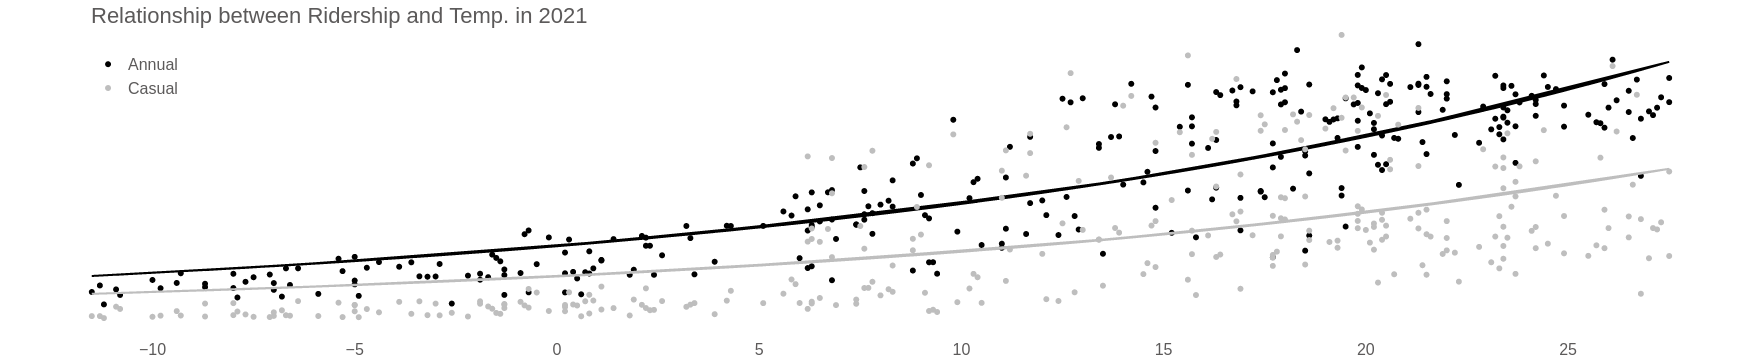

In [99]:
neighbourhood = "All"

daily_trips_weather_filtered = daily_trips_by_user_w_weather.query(
    f"area_name == '{neighbourhood}'"
)
neigh_suffix = f" in {neighbourhood.split(' (')[0]}" if neighbourhood != "All" else ""

plot_scatter(
    daily_trips_weather_filtered,
    x="tavg",
    y="num_trips",
    m_types=["Annual", "Casual"],
    l_colors=["black", "#BEBEBE"],
    ptitle=f"Relationship between Ridership and Temp.{neigh_suffix} in 2021",
)

Export aggregated hourly data to disk

In [100]:
%%time
daily_trips_by_user_w_weather.to_csv("data/processed/bikeshare_daily_aggregations_for_weather.csv", index=False)

CPU times: user 19.8 ms, sys: 3.83 ms, total: 23.6 ms
Wall time: 22.7 ms


## Links

1. [Remove whitespace around plots](https://support.sisense.com/kb/en/article/remove-whitespace-margins-from-plotly-charts)
2. [`pandas` `GROUP BY` get Q1 and Q3](https://stackoverflow.com/a/59835537/4057186)
3. [Combine ymd columns into date](https://stackoverflow.com/a/31869330/4057186)